ToDo 

[] reduce size of finetuning dataset 

[] see how performance changes as a function of the % of the finetuning dataset used

[x] create an end2end baseline 

[] change to 1 layer 

[x] update early stopping

[] investigate SGD

[] other stuff on slack 

[] randomsearch with wandb

In [28]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Testing dataset generation 

In [29]:
def eval(model, device, dataset_loader, debug, classification_report_flag = False):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


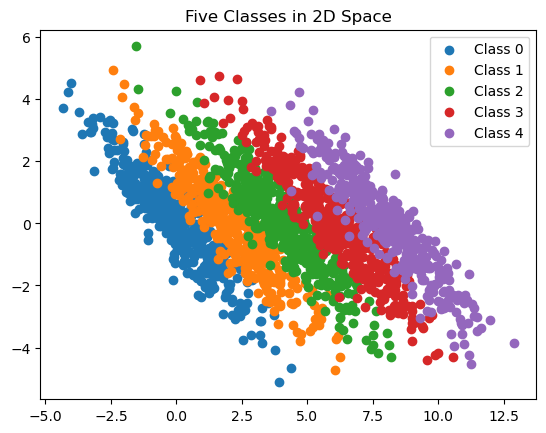

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_samples_per_class=100, n_classes=5):
    """
    Generate data for n_classes in a 2D space where the means of the data clouds
    are distributed along a horizontal line, and the data clouds have a wide 
    vertical distribution along a 45-degree slope.

    Parameters:
    - n_samples_per_class: Number of samples per class.
    - n_classes: Number of classes.

    Returns:
    - X: Data points.
    - y: Class targets.
    """
    
    # Define means for the classes along a horizontal line
    means = [(i*2, 0) for i in range(n_classes)]

    # Define a covariance matrix for 45-degree slope spread
    rotation_matrix = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                                [np.sin(np.pi/4),  np.cos(np.pi/4)]])
    base_covariance = np.array([[0.2, 0], 
                                [0, 5]])
    covariance = rotation_matrix @ base_covariance @ rotation_matrix.T

    X = np.empty((0, 2))
    y = np.empty((0,))

    for idx, mean in enumerate(means):
        class_data = np.random.multivariate_normal(mean, covariance, n_samples_per_class)
        X = np.vstack([X, class_data])
        y = np.hstack([y, [idx]*n_samples_per_class])

    return X, y

# Generate and plot the data
n_classes = 5
X, y = generate_data(n_samples_per_class = 400, n_classes=n_classes)

for idx in range(5):
    plt.scatter(X[y == idx][:, 0], X[y == idx][:, 1], label=f'Class {idx}')

plt.title("Five Classes in 2D Space")
plt.legend()
plt.show()


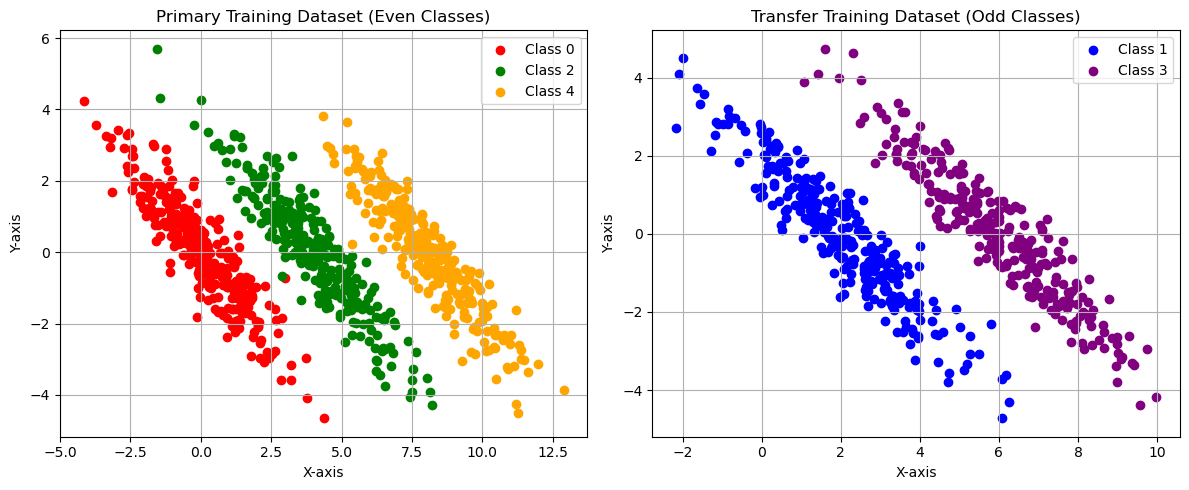

In [31]:
# Split the data into primary (even classes) and transfer (odd classes) datasets
X_primary = X[np.isin(y, [0, 2, 4])]
y_primary = y[np.isin(y, [0, 2, 4])]

X_transfer = X[np.isin(y, [1, 3])]
y_transfer = y[np.isin(y, [1, 3])]

# Splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Primary dataset: Split into train, validation, and test sets
X_primary_train, X_primary_temp, y_primary_train, y_primary_temp = train_test_split(X_primary, y_primary, test_size=(1-train_ratio))
X_primary_val, X_primary_test, y_primary_val, y_primary_test = train_test_split(X_primary_temp, y_primary_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Transfer dataset: Split into train, validation, and test sets
X_transfer_train, X_transfer_temp, y_transfer_train, y_transfer_temp = train_test_split(X_transfer, y_transfer, test_size=(1-train_ratio))
X_transfer_val, X_transfer_test, y_transfer_val, y_transfer_test = train_test_split(X_transfer_temp, y_transfer_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Plotting
# For brevity, I'm only plotting the training datasets for primary and transfer.
plt.figure(figsize=(12, 5))

# Primary training dataset
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in [0, 2, 4]:
    plt.scatter(X_primary_train[y_primary_train==i][:, 0], X_primary_train[y_primary_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Primary Training Dataset (Even Classes)')
plt.grid(True)

# Transfer training dataset
plt.subplot(1, 2, 2)
for i in [1, 3]:
    plt.scatter(X_transfer_train[y_transfer_train==i][:, 0], X_transfer_train[y_transfer_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Transfer Training Dataset (Odd Classes)')
plt.grid(True)

plt.tight_layout()
plt.show()



ADAM IS THE KEY 

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

def plot_decision_boundary_dataloader(model, dataloader, n_classes, percentage = None, Seed = None):
    # Extract data from dataloader
    X_list = []
    y_list = []
    for data, target in dataloader:
        X_list.append(data.numpy())
        y_list.append(target.numpy())
    
    # Concatenate all the data points
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Rest is similar to the original function
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    if percentage and Seed:
        plt.title(f"Decision Boundary (percentage {percentage:.2f}%, Seed: {Seed})")
    elif percentage:
        plt.title(f"Decision Boundary (percentage {percentage:.2f}%)")
    else:
        plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# Usage
# plot_decision_boundary_dataloader(model, dataloader, n_classes=2)


In [33]:
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False, plot_boundary=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   

    best_model_state = None  # To save the best model weights/state
    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []
    effective_epochs = 0

    # Loop over epochs
    for epoch in range(params['num_train']):
        effective_epochs += 1
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))
        if plot_boundary:
            plot_decision_boundary_dataloader(model, dataset.train_loader,  n_classes=2)

        if params['early_stop_patience']:
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() # This line saves the best model state.
                no_improve_epochs = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                no_improve_epochs += 1
                print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    print("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break
        
        if save_checkpoints:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # At the end of training, load the best weights if early stopping wasn't invoked 
    # (in case the final epochs did not improve performance)
    if params['early_stop_patience']:
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)

    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints, effective_epochs
    else:
        return train_acc, test_acc, model, [], effective_epochs


In [34]:
import torch.utils.data as data

def reduce_dataset(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Determine the number of samples to keep
    num_samples = int(len(dataset) * percentage)
    
    # Randomly select indices without replacement
    indices = torch.randperm(len(dataset))[:num_samples]

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

import torch
from torch.utils import data

def reduce_dataset_balanced(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage ensuring class balance.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Get unique classes and their counts
    classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)
    
    # Determine the number of samples per class to keep
    num_samples_per_class = int(len(dataset) * percentage / len(classes))
    selected_indices = []

    for class_label in classes:
        class_indices = [i for i, label in enumerate(y) if label == class_label]
        
        # Randomly select indices without replacement for each class
        class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
        selected_indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, selected_indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader



## Pretraining

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [36]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')

In [37]:
device = 'cpu'

depth = 2

params = dict(device=device,
                width=10, lr=0.01, num_train=100,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 4, activation_function='ReLU')

# Create DNN model
model = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

# Train and evaluate
train_acc, test_acc, model, _, effective_epochs = compute_training_acc_epochs(model, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 95.80%
Validation Accuracy: 95.16%
Epoch: 1 	Training Accuracy: 96.31%
Validation Accuracy: 95.42%
Epoch: 2 	Training Accuracy: 95.97%
Validation Accuracy: 95.10%
val_acc: 0.95096436744034, max_val_acc: 0.954233409610984, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 96.71%
Validation Accuracy: 95.88%
Epoch: 4 	Training Accuracy: 97.00%
Validation Accuracy: 95.98%
Epoch: 5 	Training Accuracy: 96.99%
Validation Accuracy: 96.21%
Epoch: 6 	Training Accuracy: 96.70%
Validation Accuracy: 96.04%
val_acc: 0.9604445897352076, max_val_acc: 0.9620791108205295, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 97.12%
Validation Accuracy: 96.08%
val_acc: 0.960771493952272, max_val_acc: 0.9620791108205295, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 97.25%
Validation Accuracy: 96.04%
val_acc: 0.9604445897352076, max_val_acc: 0.9620791108205295, no_improve_epochs: 3
Epoch: 9 	Training Accuracy: 97.41%
Validation Accuracy: 96.60%
Epoch: 10 	Training Accuracy: 96

In [38]:
print(model)

Sequential(
  (linear0): Linear(in_features=784, out_features=10, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (activation1): LogSoftmax(dim=1)
)


In [39]:
eval(model, device, dataset_wrapped.test_loader, debug=True, classification_report_flag = True)


Average loss: 0.0886, Accuracy: 5009.0/5139 (97%)

              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98       980
     Class 1       0.99      0.99      0.99      1135
     Class 2       0.94      0.96      0.95      1032
     Class 3       0.99      0.95      0.97      1010
     Class 4       0.97      0.98      0.98       982

    accuracy                           0.97      5139
   macro avg       0.97      0.97      0.97      5139
weighted avg       0.97      0.97      0.97      5139



0.9747032496594669

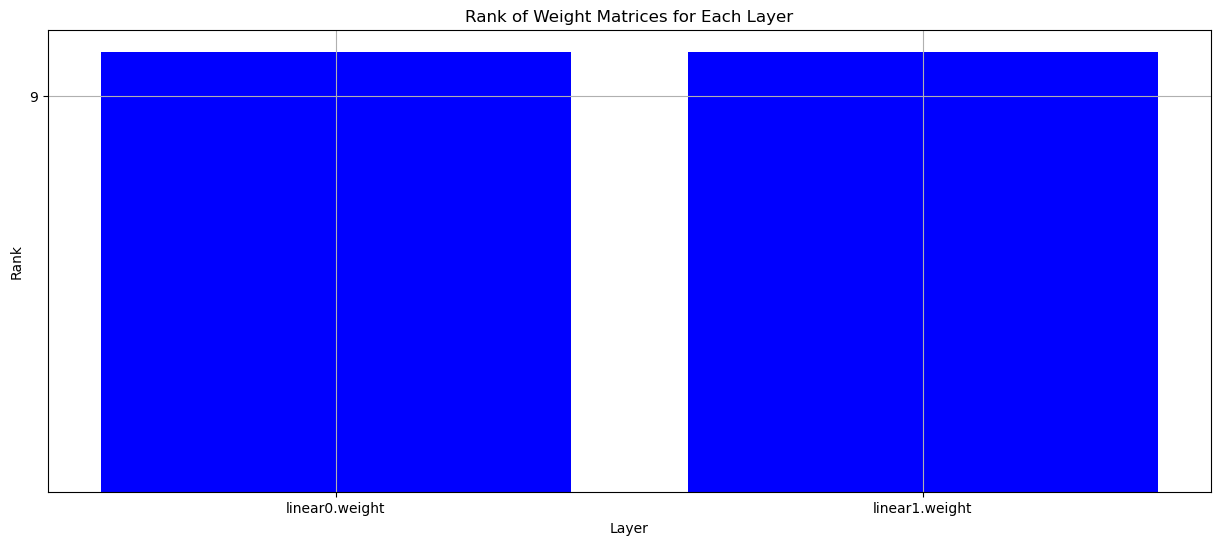

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


linear0.weight: 6.5635
linear1.weight: 6.7438


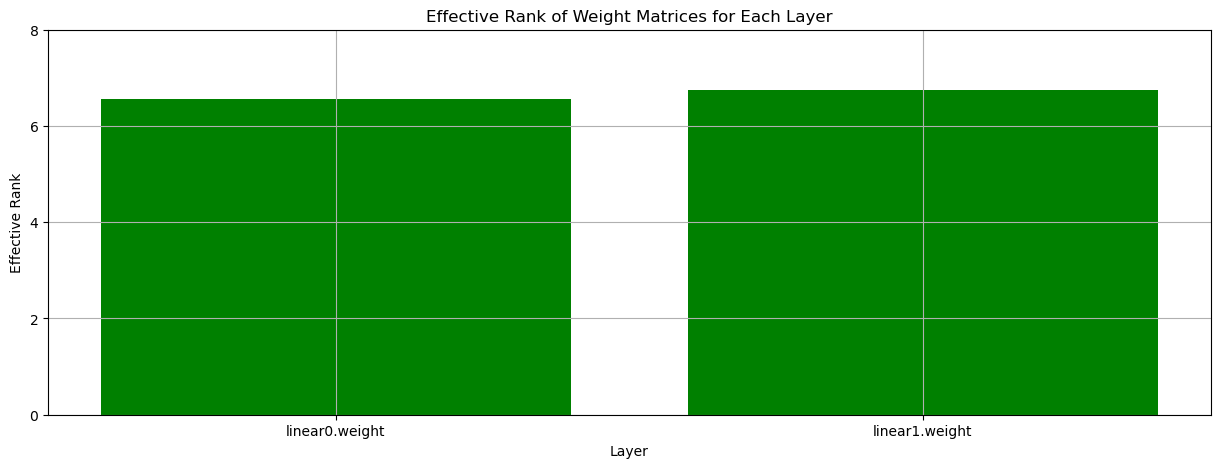

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

## Baseline model: end2end with the same architecture as the preatining model

In [42]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
model_finetuning_baseline = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

dataset_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs(model_finetuning_baseline, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Epoch: 0 	Training Accuracy: 84.88%
Validation Accuracy: 84.93%
Epoch: 1 	Training Accuracy: 89.22%
Validation Accuracy: 89.22%
Epoch: 2 	Training Accuracy: 92.18%
Validation Accuracy: 91.43%
Epoch: 3 	Training Accuracy: 91.54%
Validation Accuracy: 91.19%
val_acc: 0.9119047619047619, max_val_acc: 0.9142857142857143, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 92.82%
Validation Accuracy: 92.18%
Epoch: 5 	Training Accuracy: 93.27%
Validation Accuracy: 92.82%
Epoch: 6 	Training Accuracy: 92.59%
Validation Accuracy: 92.21%
val_acc: 0.922108843537415, max_val_acc: 0.9282312925170068, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 93.40%
Validation Accuracy: 92.89%
Epoch: 8 	Training Accuracy: 93.60%
Validation Accuracy: 93.30%
Epoch: 9 	Training Accuracy: 92.99%
Validation Accuracy: 92.31%
val_acc: 0.9231292517006803, max_val_acc: 0.9329931972789116, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 93.46%
Validation Accuracy: 93.06%
val_acc: 0.9306122448979591, max_val_acc: 0.932

linear0.weight: 6.1696
linear1.weight: 6.2473


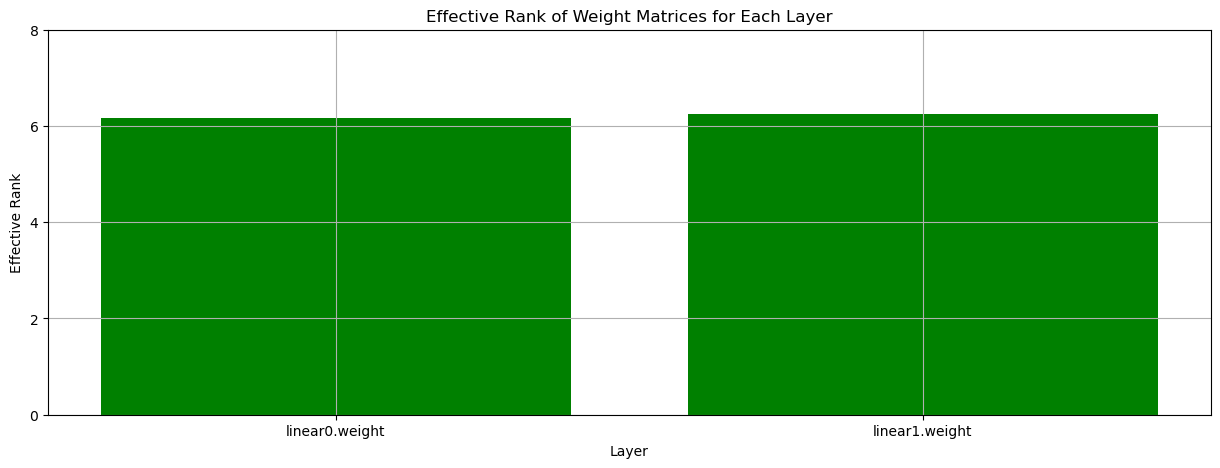

In [44]:
#eval(model, device, dataset_wrapped.test_loader, debug=True, classification_report_flag = True)
plot_layer_effective_ranks(model_finetuning_baseline)
# results, variances = compute_layer_variances_dense(model_finetuning_baseline, test_loader_transfer, device = 'cpu',cnn=False)
# plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

now with balanced classes

In [ ]:
from types import SimpleNamespace

Percentage: 0.005
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 28.46%
Validation Accuracy: 27.18%
Epoch: 1 	Training Accuracy: 35.38%
Validation Accuracy: 32.31%
Epoch: 2 	Training Accuracy: 20.00%
Validation Accuracy: 19.90%
val_acc: 0.1989795918367347, max_val_acc: 0.3231292517006803, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 30.77%
Validation Accuracy: 28.67%
val_acc: 0.286734693877551, max_val_acc: 0.3231292517006803, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 35.38%
Validation Accuracy: 36.63%
Epoch: 5 	Training Accuracy: 49.23%
Validation Accuracy: 53.27%
Epoch: 6 	Training Accuracy: 46.15%
Validation Accuracy: 48.40%
val_acc: 0.48401360544217686, max_val_acc: 0.5326530612244897, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 35.38%
Validation Accuracy: 37.01%
val_acc: 0.37006802721088433, max_val_acc: 0.5326530612244897, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 40.00%
Validation Accuracy: 39.18%
val_acc: 0.391836734693

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 26.15%
Validation Accuracy: 22.96%
Epoch: 1 	Training Accuracy: 33.85%
Validation Accuracy: 27.45%
Epoch: 2 	Training Accuracy: 26.15%
Validation Accuracy: 22.24%
val_acc: 0.22244897959183674, max_val_acc: 0.27448979591836736, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 43.85%
Validation Accuracy: 42.38%
Epoch: 4 	Training Accuracy: 30.77%
Validation Accuracy: 29.83%
val_acc: 0.29829931972789114, max_val_acc: 0.4238095238095238, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 36.15%
Validation Accuracy: 38.44%
val_acc: 0.3843537414965986, max_val_acc: 0.4238095238095238, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 44.62%
Validation Accuracy: 42.65%
Epoch: 7 	Training Accuracy: 50.77%
Validation Accuracy: 48.47%
Epoch: 8 	Training Accuracy: 39.23%
Validation Accuracy: 38.23%
val_acc: 0.38231292517006804, max_val_acc: 0.4846938775510204, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 34.62%
Validation Accuracy: 34.35%
val_acc: 0.3435374149659

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 19.90%
Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 19.90%
val_acc: 0.1989795918367347, max_val_acc: 0.1989795918367347, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 30.00%
Validation Accuracy: 26.26%
Epoch: 3 	Training Accuracy: 22.31%
Validation Accuracy: 23.37%
val_acc: 0.2336734693877551, max_val_acc: 0.26258503401360545, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 39.23%
Validation Accuracy: 38.03%
Epoch: 5 	Training Accuracy: 36.15%
Validation Accuracy: 34.05%
val_acc: 0.3404761904761905, max_val_acc: 0.3802721088435374, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 26.15%
Validation Accuracy: 26.05%
val_acc: 0.2605442176870748, max_val_acc: 0.3802721088435374, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 33.85%
Validation Accuracy: 31.26%
val_acc: 0.31258503401360543, max_val_acc: 0.3802721088435374, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 59.23%
Validation Accuracy: 53.10%
Epoch: 

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.2670, Accuracy: 2050.0/4861 (42%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       892
     Class 1       0.36      0.86      0.51       958
     Class 2       0.49      0.92      0.64      1028
     Class 3       0.98      0.05      0.09       974
     Class 4       0.38      0.23      0.29      1009

    accuracy                           0.42      4861
   macro avg       0.44      0.41      0.31      4861
weighted avg       0.45      0.42      0.31      4861

Repeat: 3, with seed 40 =========================
Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 18.71%
Epoch: 1 	Training Accuracy: 20.77%
Validation Accuracy: 21.16%
Epoch: 2 	Training Accuracy: 36.92%
Validation Accuracy: 38.64%
Epoch: 3 	Training Accuracy: 24.62%
Validation Accuracy: 23.13%
val_acc: 0.23129251700680273, max_val_acc: 0.38639455782312926, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 30.77%
Validation Accuracy: 27.79%
val_

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.2290, Accuracy: 2370.0/4861 (49%)

              precision    recall  f1-score   support

     Class 0       0.76      0.49      0.60       892
     Class 1       0.62      0.95      0.75       958
     Class 2       0.36      0.99      0.53      1028
     Class 3       0.00      0.00      0.00       974
     Class 4       1.00      0.00      0.00      1009

    accuracy                           0.49      4861
   macro avg       0.55      0.49      0.38      4861
weighted avg       0.55      0.49      0.37      4861

Repeat: 4, with seed 50 =========================
Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 18.74%
Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 19.01%
Epoch: 2 	Training Accuracy: 41.54%
Validation Accuracy: 36.26%
Epoch: 3 	Training Accuracy: 36.92%
Validation Accuracy: 32.86%
val_acc: 0.32857142857142857, max_val_acc: 0.3625850340136054, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 46.92%
Validation Accuracy: 41.36%
Epoch

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.0816, Accuracy: 2696.0/4861 (55%)

              precision    recall  f1-score   support

     Class 0       0.34      0.22      0.27       892
     Class 1       0.86      0.97      0.91       958
     Class 2       0.00      0.00      0.00      1028
     Class 3       0.52      0.91      0.66       974
     Class 4       0.46      0.67      0.55      1009

    accuracy                           0.55      4861
   macro avg       0.43      0.56      0.48      4861
weighted avg       0.43      0.55      0.47      4861

Repeat: 3, with seed 40 =========================
Epoch: 0 	Training Accuracy: 23.08%
Validation Accuracy: 16.97%
Epoch: 1 	Training Accuracy: 20.38%
Validation Accuracy: 20.41%
Epoch: 2 	Training Accuracy: 25.77%
Validation Accuracy: 25.82%
Epoch: 3 	Training Accuracy: 23.85%
Validation Accuracy: 23.81%
val_acc: 0.23809523809523808, max_val_acc: 0.25816326530612244, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 29.23%
Validation Accuracy: 30.48%
Epoc

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.3415, Accuracy: 2127.0/4861 (44%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       892
     Class 1       0.82      0.81      0.82       958
     Class 2       0.35      0.98      0.51      1028
     Class 3       0.34      0.35      0.35       974
     Class 4       0.00      0.00      0.00      1009

    accuracy                           0.44      4861
   macro avg       0.30      0.43      0.34      4861
weighted avg       0.30      0.44      0.34      4861

Repeat: 4, with seed 50 =========================
Epoch: 0 	Training Accuracy: 20.51%
Validation Accuracy: 18.84%
Epoch: 1 	Training Accuracy: 22.78%
Validation Accuracy: 21.73%
Epoch: 2 	Training Accuracy: 22.03%
Validation Accuracy: 20.68%
val_acc: 0.20680272108843537, max_val_acc: 0.2173469387755102, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 23.54%
Validation Accuracy: 21.73%
val_acc: 0.2173469387755102, max_val_acc: 0.2173469387755102, no_impr

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 46.10%
Validation Accuracy: 46.94%
Epoch: 1 	Training Accuracy: 55.81%
Validation Accuracy: 55.71%
Epoch: 2 	Training Accuracy: 60.19%
Validation Accuracy: 59.86%
Epoch: 3 	Training Accuracy: 82.29%
Validation Accuracy: 79.80%
Epoch: 4 	Training Accuracy: 80.95%
Validation Accuracy: 77.38%
val_acc: 0.7738095238095238, max_val_acc: 0.7979591836734694, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 86.29%
Validation Accuracy: 82.41%
Epoch: 6 	Training Accuracy: 88.00%
Validation Accuracy: 83.37%
Epoch: 7 	Training Accuracy: 87.81%
Validation Accuracy: 83.98%
Epoch: 8 	Training Accuracy: 88.76%
Validation Accuracy: 83.10%
val_acc: 0.830952380952381, max_val_acc: 0.8397959183673469, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 91.05%
Validation Accuracy: 86.22%
Epoch: 10 	Training Accuracy: 91.81%
Validation Accuracy: 86.09%
val_acc: 0.8608843537414966, max_val_acc: 0.8622448979591837, no_improve_epochs: 1
Epoch: 11 	Training Accuracy: 92.38%
Validation

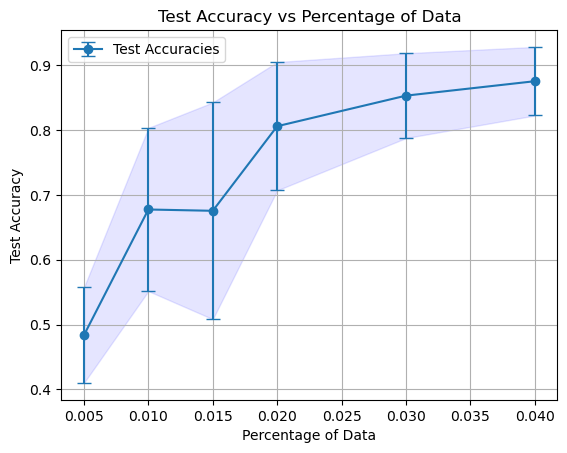

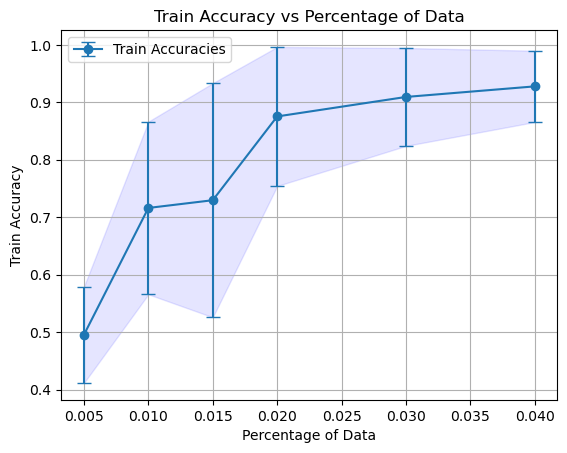

In [46]:
import numpy as np
import matplotlib.pyplot as plt

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04]
seed_set = [10, 20, 30, 40, 50]
repeats = 5

params['lr'] = 0.01   
params['num_train'] = 50
params['early_stop_patience'] = 4

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True, plot_boundary=False)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval(model_new, device, train_loader_transfer_reduced, debug=True, classification_report_flag=True)
        print('eval on full test set')
        eval(model_new, device, test_loader_transfer_reduced, debug=True, classification_report_flag=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


## Only heads and data for new classes

now with balanced classes

Percentage: 0.005
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 23.08%
Validation Accuracy: 21.39%
Epoch: 1 	Training Accuracy: 26.92%
Validation Accuracy: 25.37%
Epoch: 2 	Training Accuracy: 55.38%
Validation Accuracy: 55.95%
Epoch: 3 	Training Accuracy: 34.62%
Validation Accuracy: 35.03%
val_acc: 0.35034013605442177, max_val_acc: 0.5595238095238095, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 30.00%
Validation Accuracy: 32.96%
val_acc: 0.3295918367346939, max_val_acc: 0.5595238095238095, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 32.31%
Validation Accuracy: 34.90%
val_acc: 0.3489795918367347, max_val_acc: 0.5595238095238095, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 38.46%
Validation Accuracy: 38.64%
val_acc: 0.38639455782312926, max_val_acc: 0.5595238095238095, no_improve_epochs: 4
Early stopping invoked.
eval on reduced train set

Average loss: 1.4751, Accuracy: 50.0/130 (38%)

              precision    recall  f1-score   suppo

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.4794, Accuracy: 1884.0/4861 (39%)

              precision    recall  f1-score   support

     Class 0       0.37      0.09      0.15       892
     Class 1       0.00      0.00      0.00       958
     Class 2       0.41      0.98      0.58      1028
     Class 3       0.35      0.77      0.48       974
     Class 4       0.98      0.04      0.09      1009

    accuracy                           0.39      4861
   macro avg       0.42      0.38      0.26      4861
weighted avg       0.43      0.39      0.26      4861

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 3.85%
Validation Accuracy: 1.36%
Epoch: 1 	Training Accuracy: 10.77%
Validation Accuracy: 10.44%
Epoch: 2 	Training Accuracy: 35.38%
Validation Accuracy: 31.09%
Epoch: 3 	Training Accuracy: 36.15%
Validation Accuracy: 36.56%
Epoch: 4 	Training Accuracy: 43.85%
Validation Accuracy: 44.86%
Epoch: 5 	Training Accuracy: 38.46%
Validation Accuracy: 40.85%
val_acc: 0.4085034013605442

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.3976, Accuracy: 1846.0/4861 (38%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       892
     Class 1       0.29      1.00      0.45       958
     Class 2       0.55      0.85      0.67      1028
     Class 3       1.00      0.02      0.03       974
     Class 4       0.00      0.00      0.00      1009

    accuracy                           0.38      4861
   macro avg       0.37      0.37      0.23      4861
weighted avg       0.37      0.38      0.24      4861

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 34.62%
Validation Accuracy: 37.35%
Epoch: 1 	Training Accuracy: 31.54%
Validation Accuracy: 29.01%
val_acc: 0.2901360544217687, max_val_acc: 0.373469387755102, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 51.54%
Validation Accuracy: 51.87%
Epoch: 3 	Training Accuracy: 43.85%
Validation Accuracy: 36.90%
val_acc: 0.36904761904761907, max_val_acc: 0.5187074829931972, no_impro

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.3528, Accuracy: 2220.0/4861 (46%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       892
     Class 1       0.77      0.59      0.67       958
     Class 2       0.87      0.67      0.76      1028
     Class 3       0.29      0.99      0.45       974
     Class 4       0.00      0.00      0.00      1009

    accuracy                           0.46      4861
   macro avg       0.39      0.45      0.37      4861
weighted avg       0.39      0.46      0.38      4861

Repeat: 3, with seed 40 =========================
Epoch: 0 	Training Accuracy: 24.62%
Validation Accuracy: 25.61%
Epoch: 1 	Training Accuracy: 20.77%
Validation Accuracy: 21.87%
val_acc: 0.21870748299319728, max_val_acc: 0.25612244897959185, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
val_acc: 0.20374149659863947, max_val_acc: 0.25612244897959185, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 20.00%
Validation 

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.7159, Accuracy: 958.0/4861 (20%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       892
     Class 1       0.20      1.00      0.33       958
     Class 2       0.00      0.00      0.00      1028
     Class 3       0.00      0.00      0.00       974
     Class 4       0.00      0.00      0.00      1009

    accuracy                           0.20      4861
   macro avg       0.04      0.20      0.07      4861
weighted avg       0.04      0.20      0.06      4861

Repeat: 4, with seed 50 =========================
Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
Epoch: 1 	Training Accuracy: 30.77%
Validation Accuracy: 31.70%
Epoch: 2 	Training Accuracy: 24.62%
Validation Accuracy: 24.56%
val_acc: 0.24557823129251702, max_val_acc: 0.31700680272108844, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 57.69%
Validation Accuracy: 53.61%
Epoch: 4 	Training Accuracy: 28.46%
Validation Accuracy: 27.65%
val_a

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 40.38%
Validation Accuracy: 35.17%
Epoch: 1 	Training Accuracy: 33.08%
Validation Accuracy: 31.16%
val_acc: 0.3115646258503401, max_val_acc: 0.3517006802721088, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 51.54%
Validation Accuracy: 49.22%
Epoch: 3 	Training Accuracy: 49.23%
Validation Accuracy: 48.61%
val_acc: 0.4860544217687075, max_val_acc: 0.4921768707482993, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 79.23%
Validation Accuracy: 73.16%
Epoch: 5 	Training Accuracy: 54.62%
Validation Accuracy: 49.32%
val_acc: 0.4931972789115646, max_val_acc: 0.7316326530612245, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 77.31%
Validation Accuracy: 69.52%
val_acc: 0.6952380952380952, max_val_acc: 0.7316326530612245, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 75.00%
Validation Accuracy: 67.76%
val_acc: 0.6775510204081633, max_val_acc: 0.7316326530612245, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 76.15%
Validation Accuracy: 67.35%
val_acc: 

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.5488, Accuracy: 1225.0/4861 (25%)

              precision    recall  f1-score   support

     Class 0       0.52      0.24      0.32       892
     Class 1       0.00      0.00      0.00       958
     Class 2       0.00      0.00      0.00      1028
     Class 3       0.22      1.00      0.36       974
     Class 4       0.79      0.04      0.08      1009

    accuracy                           0.25      4861
   macro avg       0.31      0.26      0.15      4861
weighted avg       0.30      0.25      0.15      4861

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 36.15%
Validation Accuracy: 33.78%
Epoch: 1 	Training Accuracy: 35.38%
Validation Accuracy: 33.37%
val_acc: 0.3336734693877551, max_val_acc: 0.3377551020408163, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 37.69%
Validation Accuracy: 34.15%
Epoch: 3 	Training Accuracy: 45.77%
Validation Accuracy: 42.24%
Epoch: 4 	Training Accuracy: 33.85%
Validation Accuracy: 30.51%
val_ac

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 40.51%
Validation Accuracy: 41.36%
Epoch: 1 	Training Accuracy: 64.05%
Validation Accuracy: 65.00%
Epoch: 2 	Training Accuracy: 67.09%
Validation Accuracy: 65.51%
Epoch: 3 	Training Accuracy: 76.71%
Validation Accuracy: 71.80%
Epoch: 4 	Training Accuracy: 70.13%
Validation Accuracy: 67.04%
val_acc: 0.6704081632653062, max_val_acc: 0.7180272108843537, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 86.84%
Validation Accuracy: 82.86%
Epoch: 6 	Training Accuracy: 85.32%
Validation Accuracy: 80.41%
val_acc: 0.8040816326530612, max_val_acc: 0.8285714285714286, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 86.58%
Validation Accuracy: 83.61%
Epoch: 8 	Training Accuracy: 88.86%
Validation Accuracy: 82.28%
val_acc: 0.8227891156462585, max_val_acc: 0.8360544217687075, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 88.86%
Validation Accuracy: 84.05%
Epoch: 10 	Training Accuracy: 87.09%
Validation Accuracy: 82.18%
val_acc: 0.8217687074829932, max_val_acc: 0.84

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.0247, Accuracy: 2789.0/4861 (57%)

              precision    recall  f1-score   support

     Class 0       0.51      0.44      0.47       892
     Class 1       0.62      0.92      0.74       958
     Class 2       0.00      0.00      0.00      1028
     Class 3       0.81      0.65      0.72       974
     Class 4       0.46      0.87      0.61      1009

    accuracy                           0.57      4861
   macro avg       0.48      0.58      0.51      4861
weighted avg       0.48      0.57      0.50      4861

Repeat: 3, with seed 40 =========================
Epoch: 0 	Training Accuracy: 23.04%
Validation Accuracy: 22.76%
Epoch: 1 	Training Accuracy: 42.03%
Validation Accuracy: 42.38%
Epoch: 2 	Training Accuracy: 34.94%
Validation Accuracy: 33.88%
val_acc: 0.33877551020408164, max_val_acc: 0.4238095238095238, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 55.95%
Validation Accuracy: 53.57%
Epoch: 4 	Training Accuracy: 54.68%
Validation Accuracy: 55.58%
Epoch

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Average loss: 1.5071, Accuracy: 1242.0/4861 (26%)

              precision    recall  f1-score   support

     Class 0       0.30      0.98      0.46       892
     Class 1       0.19      0.38      0.25       958
     Class 2       0.00      0.00      0.00      1028
     Class 3       0.00      0.00      0.00       974
     Class 4       0.00      0.00      0.00      1009

    accuracy                           0.26      4861
   macro avg       0.10      0.27      0.14      4861
weighted avg       0.09      0.26      0.13      4861

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 49.33%
Validation Accuracy: 50.88%
Epoch: 1 	Training Accuracy: 56.76%
Validation Accuracy: 54.90%
Epoch: 2 	Training Accuracy: 72.19%
Validation Accuracy: 71.56%
Epoch: 3 	Training Accuracy: 69.14%
Validation Accuracy: 69.01%
val_acc: 0.6901360544217687, max_val_acc: 0.7156462585034014, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 75.81%
Validation Accuracy: 75.65%
Epoch:

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch: 0 	Training Accuracy: 46.10%
Validation Accuracy: 46.94%
Epoch: 1 	Training Accuracy: 55.81%
Validation Accuracy: 55.71%
Epoch: 2 	Training Accuracy: 60.19%
Validation Accuracy: 59.86%
Epoch: 3 	Training Accuracy: 82.29%
Validation Accuracy: 79.80%
Epoch: 4 	Training Accuracy: 80.95%
Validation Accuracy: 77.38%
val_acc: 0.7738095238095238, max_val_acc: 0.7979591836734694, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 86.29%
Validation Accuracy: 82.41%
Epoch: 6 	Training Accuracy: 88.00%
Validation Accuracy: 83.37%
Epoch: 7 	Training Accuracy: 87.81%
Validation Accuracy: 83.98%
Epoch: 8 	Training Accuracy: 88.76%
Validation Accuracy: 83.10%
val_acc: 0.830952380952381, max_val_acc: 0.8397959183673469, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 91.05%
Validation Accuracy: 86.22%
Epoch: 10 	Training Accuracy: 91.81%
Validation Accuracy: 86.09%
val_acc: 0.8608843537414966, max_val_acc: 0.8622448979591837, no_improve_epochs: 1
Epoch: 11 	Training Accuracy: 92.38%
Validation

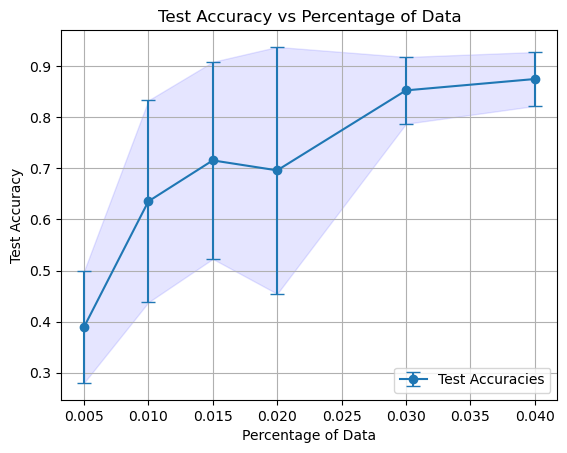

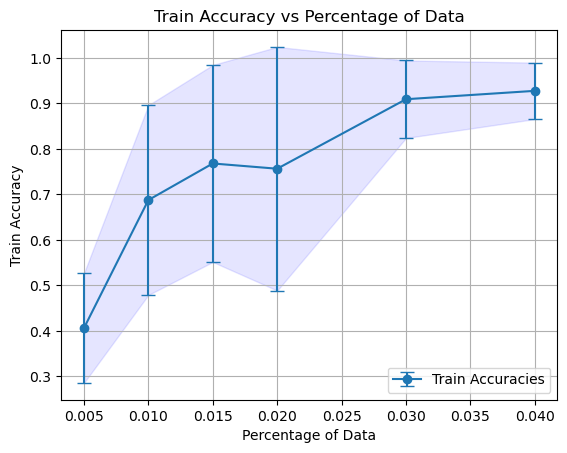

In [57]:
import numpy as np
import matplotlib.pyplot as plt

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04]
seed_set = [10, 20, 30, 40, 50]
repeats = 5

params['lr'] = 0.01  
params['num_train'] = 50
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth) not in name:
                model_new._parameters[name] = param

        #freeze them 
        # for name, param in model.named_parameters():
        #     if "linear" + str(depth-1) not in name:
        #         param.requires_grad = False
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True, plot_boundary=False)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval(model_new, device, train_loader_transfer_reduced, debug=True, classification_report_flag=True)
        print('eval on full test set')
        eval(model_new, device, test_loader_transfer_reduced, debug=True, classification_report_flag=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
print(model_new)

Sequential(
  (linear0): Linear(in_features=784, out_features=10, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (activation1): LogSoftmax(dim=1)
)


In [59]:
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:
        #model_new._parameters[name] = param
        print('layer name: ', name)
        


layer name:  linear0.weight
layer name:  linear0.bias


In [60]:
print(f'end to end {epochs_taken}')
print(f'finetune {epochs_taken_finetune}')

end to end {0.005: [10, 12, 13, 11, 16], 0.01: [24, 20, 15, 23, 13], 0.015: [28, 33, 29, 27, 15], 0.02: [30, 28, 24, 12, 38], 0.03: [18, 24, 13, 21, 36], 0.04: [21, 18, 20, 19, 17]}
finetune {0.005: [7, 9, 7, 5, 8], 0.01: [9, 7, 18, 18, 17], 0.015: [10, 20, 13, 39, 16], 0.02: [16, 11, 24, 12, 38], 0.03: [18, 24, 13, 21, 36], 0.04: [21, 18, 20, 19, 17]}


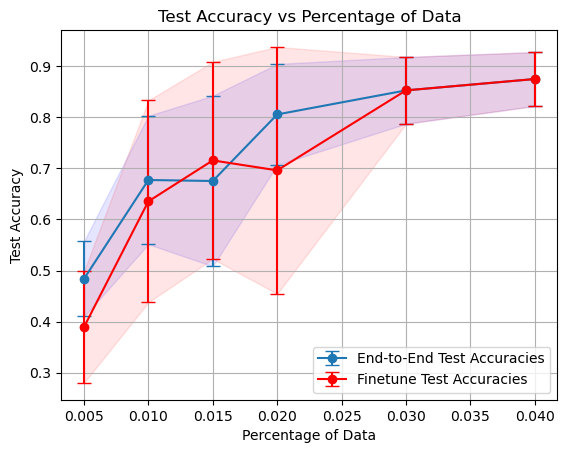

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


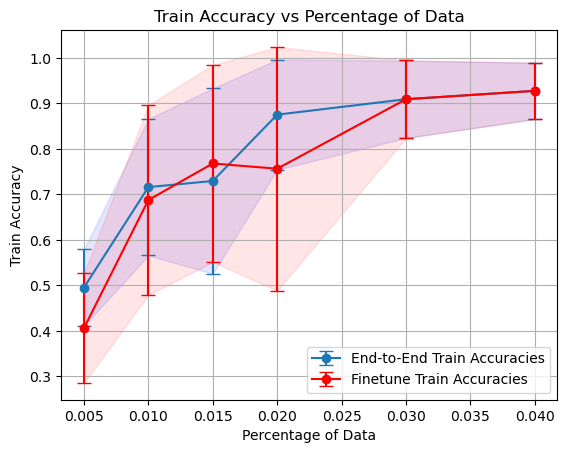

In [62]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


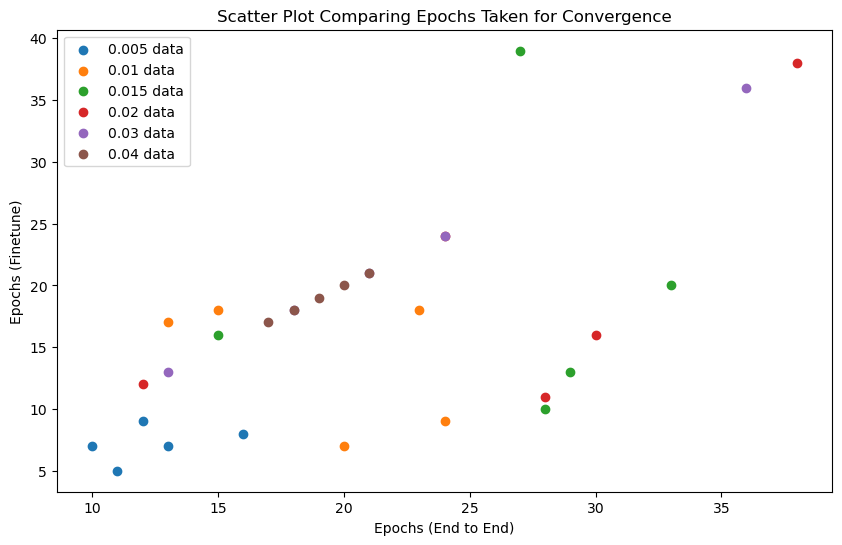

In [63]:
plt.figure(figsize=(10, 6))
for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()


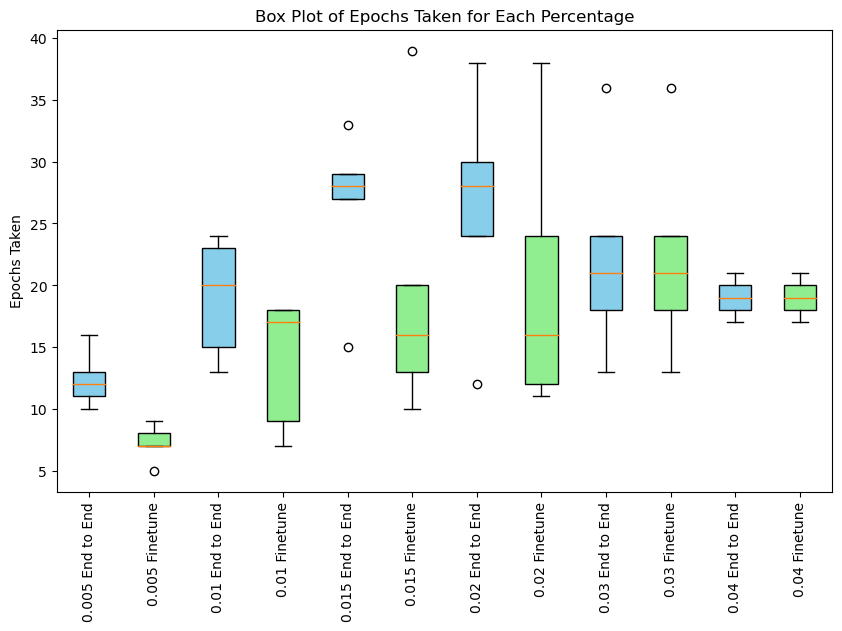

In [64]:
import matplotlib.pyplot as plt

# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
